# Tiny example for Flux.jl

This example is slightly a slightly adapted version of the [tutorial example by Flux.jl](https://fluxml.ai/Flux.jl/stable/models/quickstart/). The underlying problem for the XOR function goes back to the book by Minsky 1969 [see also](https://en.wikipedia.org/wiki/Perceptrons_(book))

In [1]:
# Packages
using Pkg
Pkg.activate(".")
using Flux
using Plots
using CUDA # If this fails after a while, then you may have to restart the computer
using Statistics
using ProgressMeter

  Activating project at `~/src_nobackup/julia_ml_tests.jl.git`


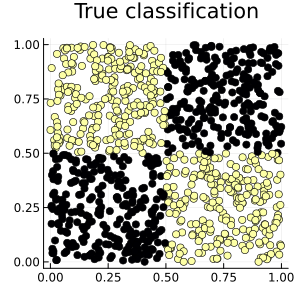

In [2]:
# Generate some data for the XOR problem: vectors of length 2, as columns of a matrix:
# Note that Flux expects Float32 arrays by default
noisy = rand(Float32, 2, 1000)                                    # 2×1000 Matrix{Float32}
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)]   # 1000-element Vector{Bool}

scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false, size=(300,300))

In [3]:
# Define our model, a multi-layer perceptron with one hidden layer of size 3:
model = Chain(
    Dense(2 => 3, tanh),   # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2),
    softmax) |> gpu        # move model to GPU, if available


Chain(
  Dense(2 => 3, tanh),                  # 9 parameters
  BatchNorm(3),                         # 6 parameters, plus 6
  Dense(3 => 2),                        # 8 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 23 parameters,
          # plus 2 non-trainable, 6 parameters, summarysize 1.070 KiB.

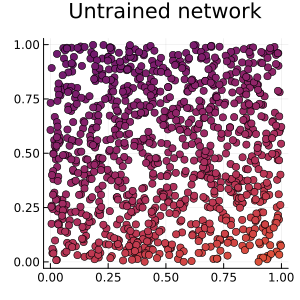

In [4]:
# Run the untrained model
# The model encapsulates parameters, randomly initialised. Its initial output is:
out1 = model(noisy |> gpu) |> cpu                                 # 2×1000 Matrix{Float32}

scatter(noisy[1,:], noisy[2,:], zcolor=out1[1,:], title="Untrained network", label="", clims=(0,1), legend=false, size=(300,300))
# The output is some smooth random function of the input.

In [5]:
# Train the model

# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target) |> gpu, batchsize=64, shuffle=true);
# DataLoader with first element: (2×64 Matrix{Float32}, 2×64 OneHotMatrix); it cuts the data in pieces

optim = Flux.setup(Flux.Adam(0.01), model)  # will store optimiser momentum, etc.

# Training loop, using the whole data set 1000 times:
losses = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

optim # parameters, momenta and output have all changed
out2 = model(noisy |> gpu) |> cpu  # first row is prob. of true, second row p(false)


Progress:   0%|▏                                        |  ETA: 2:43:01

Progress:   9%|███▊                                     |  ETA: 0:03:30

Progress:  10%|████▎                                    |  ETA: 0:03:02

Progress:  11%|████▋                                    |  ETA: 0:02:47

Progress:  12%|█████▏                                   |  ETA: 0:02:29

Progress:  14%|█████▌                                   |  ETA: 0:02:16

Progress:  14%|█████▉                                   |  ETA: 0:02:07

Progress:  16%|██████▍                                  |  ETA: 0:01:56

Progress:  17%|██████▉                                  |  ETA: 0:01:48

Progress:  18%|███████▎                                 |  ETA: 0:01:41

Progress:  19%|███████▊                                 |  ETA: 0:01:34

Progress:  20%|████████▎                                |  ETA: 0:01:28

Progress:  21%|████████▋                                |  ETA: 0:01:23

Progress:  22%|█████████                                |  ETA: 0:01:18

Progress:  23%|█████████▌                               |  ETA: 0:01:14

Progress:  24%|█████████▉                               |  ETA: 0:01:10

Progress:  25%|██████████▍                              |  ETA: 0:01:06

Progress:  26%|██████████▉                              |  ETA: 0:01:03

Progress:  28%|███████████▍                             |  ETA: 0:01:00

Progress:  29%|███████████▊                             |  ETA: 0:00:56

Progress:  30%|████████████▎                            |  ETA: 0:00:54

Progress:  31%|████████████▋                            |  ETA: 0:00:52

Progress:  32%|█████████████▏                           |  ETA: 0:00:49

Progress:  33%|█████████████▋                           |  ETA: 0:00:47

Progress:  34%|██████████████                           |  ETA: 0:00:45

Progress:  35%|██████████████▌                          |  ETA: 0:00:43

Progress:  36%|███████████████                          |  ETA: 0:00:41

Progress:  37%|███████████████▍                         |  ETA: 0:00:40

Progress:  39%|███████████████▉                         |  ETA: 0:00:38

Progress:  40%|████████████████▎                        |  ETA: 0:00:36

Progress:  41%|████████████████▊                        |  ETA: 0:00:35

Progress:  42%|█████████████████▎                       |  ETA: 0:00:33

Progress:  43%|█████████████████▋                       |  ETA: 0:00:32

Progress:  44%|██████████████████▏                      |  ETA: 0:00:31

Progress:  45%|██████████████████▋                      |  ETA: 0:00:30

Progress:  46%|███████████████████                      |  ETA: 0:00:29

Progress:  47%|███████████████████▍                     |  ETA: 0:00:27

Progress:  49%|███████████████████▉                     |  ETA: 0:00:26

Progress:  50%|████████████████████▍                    |  ETA: 0:00:25

Progress:  51%|████████████████████▊                    |  ETA: 0:00:24

Progress:  52%|█████████████████████▎                   |  ETA: 0:00:23

Progress:  53%|█████████████████████▊                   |  ETA: 0:00:23

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:22

Progress:  55%|██████████████████████▋                  |  ETA: 0:00:21

Progress:  56%|███████████████████████                  |  ETA: 0:00:20

Progress:  57%|███████████████████████▌                 |  ETA: 0:00:19

Progress:  58%|████████████████████████                 |  ETA: 0:00:18

Progress:  60%|████████████████████████▍                |  ETA: 0:00:18

Progress:  61%|████████████████████████▉                |  ETA: 0:00:17

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:16

Progress:  63%|█████████████████████████▊               |  ETA: 0:00:16

Progress:  64%|██████████████████████████▏              |  ETA: 0:00:15

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:14

Progress:  66%|███████████████████████████▏             |  ETA: 0:00:14

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:13

Progress:  68%|████████████████████████████             |  ETA: 0:00:13

Progress:  69%|████████████████████████████▍            |  ETA: 0:00:12

Progress:  70%|████████████████████████████▉            |  ETA: 0:00:11

Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:11

Progress:  72%|█████████████████████████████▊           |  ETA: 0:00:10

Progress:  74%|██████████████████████████████▏          |  ETA: 0:00:10

Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:09

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:09

Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:08

Progress:  78%|████████████████████████████████         |  ETA: 0:00:08

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:07

Progress:  80%|████████████████████████████████▉        |  ETA: 0:00:07

Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:06

Progress:  82%|█████████████████████████████████▉       |  ETA: 0:00:06

Progress:  84%|██████████████████████████████████▎      |  ETA: 0:00:06

Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:05

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:05

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:04

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:04

Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:04

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:03

Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:03

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:02

Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:02

Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:02

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:01

Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


2×1000 Matrix{Float32}:
 1.24756f-7  2.02133f-8  0.7675  …  3.06466f-6  0.000152723  0.291749
 1.0         1.0         0.2325     0.999997    0.999847     0.708251

Accuracy of the trained model on the training set: 0.976


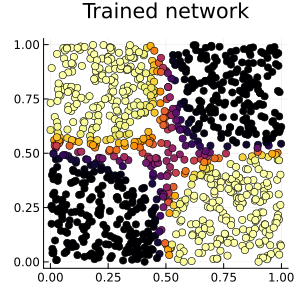

In [6]:
# Evaluate the trained model (on the training set for now / a bad practice) 
acc_trained = mean((out2[1,:] .> 0.5) .== truth)  # accuracy 94% so far!
println("Accuracy of the trained model on the training set: ", acc_trained)

scatter(noisy[1,:], noisy[2,:], zcolor=out2[1,:], title="Trained network", legend=false, size=(300,300))


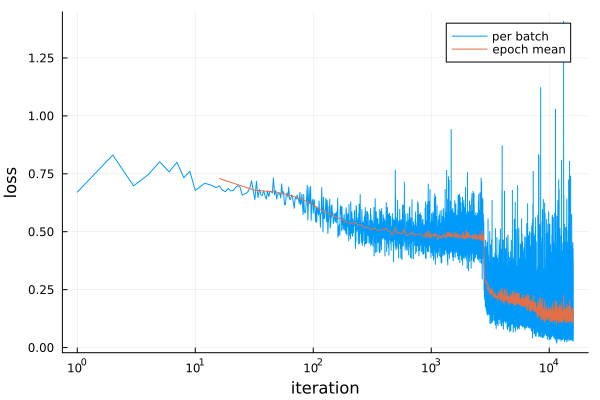

In [7]:
# Plot the loss function as it changes over the iterations
plot(losses; xaxis=(:log10, "iteration"),
    yaxis="loss", label="per batch")
n = length(loader)
plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),
    label="epoch mean")